# Bounding box detection - Racoon data (Object Localization)


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

Please note that each image in the dataset has one racoon.

### Import the necessary libraries

In [1]:
import glob
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape
from keras.layers import Dropout, Embedding, LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras import optimizers
from keras.optimizers import Adam
from keras import regularizers
from keras import layers

Using TensorFlow backend.


In [0]:
from keras.applications.mobilenet import MobileNet, preprocess_input

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Change directory

In [0]:
import os
os.chdir('//content/drive/My Drive/Colab Notebooks')

In [10]:
!ls -l

total 1022
-rw------- 1 root root  18573 Aug  3 12:24 '1. Object_Detection_Pascal VOC E2E.ipynb'
-rw------- 1 root root  34723 Jun 16 02:52  cifar10_Externallab.ipynb
-rw------- 1 root root   6421 Jun  8 07:53  Cifar10.ipynb
-rw------- 1 root root   9726 Jun  8 04:55  cpu.ipynb
-rw------- 1 root root  13304 Jun  8 06:26  Dropout.ipynb
-rw------- 1 root root 103050 Jul 28 14:13  NNDL_R7_Project2.ipynb
-rw------- 1 root root  29871 Jun 15 18:11  R7_ExternalLab_Questions_Hyd_Nov18.ipynb
-rw------- 1 root root  35305 Jun 15 18:01  R7_InternalLab_Questions_Hyd_Nov18.ipynb
-rw------- 1 root root  20261 Jul  7 04:35  R8_External_Lab_Questions-HYD_AIML_Nov18.ipynb
-rw------- 1 root root  26075 Jul 20 16:33 'R8_External_Lab _teju.ipynb'
-rw------- 1 root root  48145 Jul 13 10:20  R8_Internal_Lab_Questions-HYD_AIML_Nov18.ipynb
-rw------- 1 root root 679421 Aug  4 15:48  R9_Internal_Lab_Questions.ipynb
-rw------- 1 root root  16964 Aug  3 08:40  shakelist.ipynb
-rw------- 1 root root    287 Jun  

### Load the training data from train.csv file

In [13]:
#train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_labels.csv')

train_labels = pd.read_csv('/content/train_labels.csv')
print(train_labels.head())

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


In [0]:
#train_labels['file_path'] = "/content/drive/My Drive/R9/images/"+train_labels['filename']

train_labels['file_path'] = "/content/IMG_20140701_222455588.jpg"+train_labels['filename']

In [25]:
train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,file_path
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,/content/IMG_20140701_222455588.jpgraccoon-17.jpg
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,/content/IMG_20140701_222455588.jpgraccoon-11.jpg
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,/content/IMG_20140701_222455588.jpgraccoon-63.jpg
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,/content/IMG_20140701_222455588.jpgraccoon-63.jpg
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,/content/IMG_20140701_222455588.jpgraccoon-60.jpg


### Print the shape of the train dataset

In [26]:
train_labels.shape

(173, 9)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
img_size = 128

#### Build a Batch Generator

The batch generator should do the following:

1. Take batch_size and dataframe (build from csv file above) as input
2. Build random row indexes equal to batch size from the dataframe
3. Based on random indexes created above, read the dataframe to do following:
   - Read image and resize the image to 128x128
   - Convert it to numpy array
   - Read bounding box co-ordinates from dataframe for this image
   - Resize co-ordinates as we have resized the image
   - 'yield' batch of images and batch of co-ordinates
   
Please note that there is no classification task here as all images do have racoon's in them.

In [28]:
import cv2
#Pickup a random image number
img_num = np.random.randint(0, train_labels.shape[0])

#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(train_labels.loc[img_num,'file_path'])
cv2.rectangle(img, 
             (train_labels.loc[img_num, 'xmin'],train_labels.loc[img_num, 'ymin']),
             (train_labels.loc[img_num, 'xmax'],train_labels.loc[img_num, 'ymax']), 
             (0,255,0),
             2)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(img)
plt.show()

error: ignored

In [0]:
def batch_generator(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, img_size, img_size, 3))
        #Classification Labels 
        #batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'file_path'], 
                                                        target_size=(img_size, img_size))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array

            #Read image classification label & convert to one hot vector
            #cl_label = df.loc[image_nums[i], 'Label']
            #cl_label = tf.keras.utils.to_categorical(cl_label, num_classes=len(num_classes))
            #batch_labels[i] = cl_label

            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * img_size/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * img_size/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * img_size/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * img_size/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        batch_images = preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/img_size

        #Return batch - use yield function to make it a python generator
        yield batch_images, [batch_bboxes]

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(128,128,3), include_top=False)

W0804 10:53:12.933669 139845148321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



17227776/17225924 [==============================] - 0s 0us/step


### Define a custom metric function IoU which calculates Intersection Over Union

In [0]:
def calculate_iou(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
for layer in model.layers:
  layer.trainable = False
  
x = model.layers[-1].output
x = Conv2D(4,kernel_size=4, name="coords")(x)
x = Reshape((4,))(x)

model = Model(inputs=model.input, output=[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  


In [0]:
model.compile(optimizer='adam', loss='mse',metrics=[IoU])

W0804 11:05:52.497959 139845148321664 deprecation.py:323] From <ipython-input-108-eb690ef8a3c9>:25: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
batchsize = 32
train_generator = batch_generator(train_labels, batch_size=batchsize)

In [0]:
from keras.backend import epsilon

In [0]:
model.fit_generator(train_generator, 
                          epochs=30,
                          steps_per_epoch= train_labels.shape[0]//batchsize)

Epoch 1/30
5/5 [==============================] - 19s 4s/step - loss: 11.0802 - IoU: 0.0534
Epoch 2/30
5/5 [==============================] - 8s 2s/step - loss: 6.8559 - IoU: 0.1391
Epoch 3/30
5/5 [==============================] - 6s 1s/step - loss: 5.6432 - IoU: 0.1778
Epoch 4/30
5/5 [==============================] - 6s 1s/step - loss: 3.8834 - IoU: 0.0913
Epoch 5/30
5/5 [==============================] - 5s 1s/step - loss: 2.7297 - IoU: 0.1292
Epoch 6/30
5/5 [==============================] - 5s 1s/step - loss: 2.6151 - IoU: 0.1638
Epoch 7/30
5/5 [==============================] - 5s 1s/step - loss: 2.2976 - IoU: 0.0992
Epoch 8/30
5/5 [==============================] - 5s 1s/step - loss: 2.8239 - IoU: 0.1345
Epoch 9/30
5/5 [==============================] - 5s 999ms/step - loss: 2.4554 - IoU: 0.0877
Epoch 10/30
5/5 [==============================] - 5s 1s/step - loss: 2.1694 - IoU: 0.0845
Epoch 11/30
5/5 [==============================] - 5s 1s/step - loss: 2.4211 - IoU: 0.2052
Epo

### Pick a test image from the given data

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

### Predict the coordinates of the bounding box for the given test image

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
#Drive is already mounted

#### Change your present working directory

In [0]:
#I am on the same working directory

### Load your data file

In [0]:
#df = pd.read_csv('/content/drive/My Drive/R9/daily-minimum-temperatures-in-me.csv', index_col='Date')

df = pd.read_csv('/content/daily-minimum-temperatures-in-me.csv', index_col='Date')




In [30]:
df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Plot data

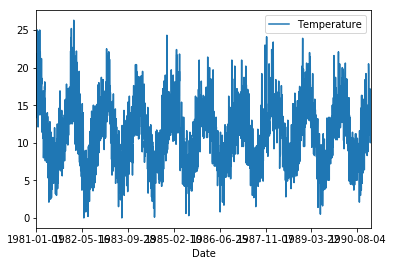

In [31]:
df.plot()

#### Descibe your dataframe

In [32]:
df.describe

<bound method NDFrame.describe of             Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8
1981-01-06         15.8
1981-01-07         15.8
1981-01-08         17.4
1981-01-09         21.8
1981-01-10         20.0
1981-01-11         16.2
1981-01-12         13.3
1981-01-13         16.7
1981-01-14         21.5
1981-01-15         25.0
1981-01-16         20.7
1981-01-17         20.6
1981-01-18         24.8
1981-01-19         17.7
1981-01-20         15.5
1981-01-21         18.2
1981-01-22         12.1
1981-01-23         14.4
1981-01-24         16.0
1981-01-25         16.5
1981-01-26         18.7
1981-01-27         19.4
1981-01-28         17.2
1981-01-29         15.5
1981-01-30         15.1
...                 ...
1990-12-02         13.2
1990-12-03         16.2
1990-12-04         17.3
1990-12-05         20.5
1990-12-06         20.2
1990-12-07         19.4
1990-12-08         15.5
1990-1

#### Check for null values

In [33]:
df.isnull().sum()
#None

Temperature    0
dtype: int64

#### Drop null values

In [0]:
df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa41a530da0>]],
      dtype=object)

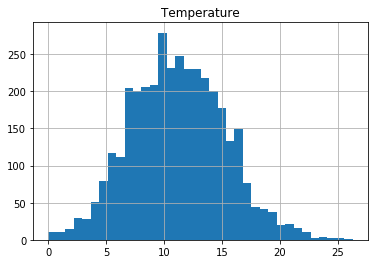

In [35]:
df.hist(bins='auto')

#### Check the maximum and minimum values

In [36]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')

#### Check the maximum and minimum values of scaled data

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [39]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [41]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [43]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [44]:
X_train[:3], y_train[:3]

(array([[0.7870723 ],
        [0.68060837],
        [0.71482889]]), array([0.68060837, 0.71482889, 0.55513311]))

In [45]:
X_test[:3], y_test[:3]

(array([[0.58174907],
        [0.54372626],
        [0.513308  ]]), array([0.54372626, 0.513308  , 0.57034222]))

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [47]:
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

W0804 16:15:01.056962 140344239073152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 16:15:01.115416 140344239073152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 16:15:01.121293 140344239073152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 16:15:01.365396 140344239073152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Summarize your model

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [49]:
# The network is trained for 100 epochs and a batch size of 1 is used.
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=True)

W0804 16:15:09.409167 140344239073152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0804 16:15:09.841565 140344239073152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0804 16:15:09.922024 140344239073152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
 - 15s - loss: 0.0200
Epoch 2/10
 - 10s - loss: 0.0158
Epoch 3/10
 - 10s - loss: 0.0137
Epoch 4/10
 - 10s - loss: 0.0127
Epoch 5/10
 - 10s - loss: 0.0125
Epoch 6/10
 - 10s - loss: 0.0119
Epoch 7/10
 - 10s - loss: 0.0116
Epoch 8/10
 - 10s - loss: 0.0113
Epoch 9/10
 - 10s - loss: 0.0106
Epoch 10/10
 - 10s - loss: 0.0107


## Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [52]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.71 RMSE
Test Score: 2.56 RMSE


## Plot the results

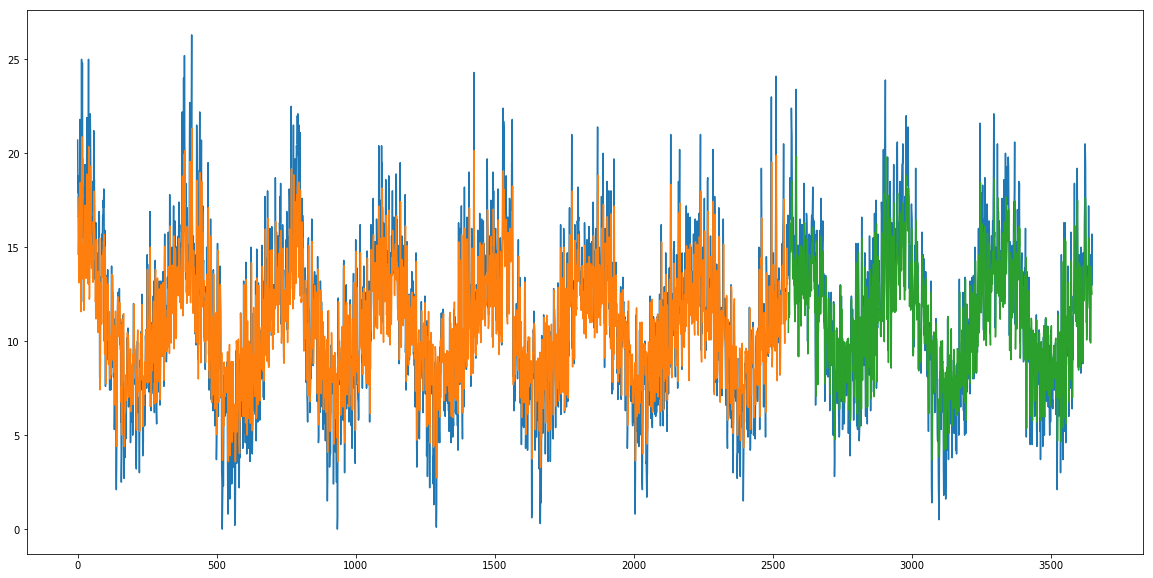

In [53]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()